# Lab-10:  Advanced training of Neural Networks in Pytorch

You've already trained pretty efficient and precise neural networks. However, there are some methods that can make the training faster and more reliable. In this lab you're going to familiarize yourself with such techniques.


## Objectives:
Learn how to use:
1. Data augmentation; 
2. Batch normalization;
3. Dropout;
4. Early stopping;
5. Learning rate scheduling;
6. Tensorboard for training control.

# 1) Data augmentation
We're going to use a new dataset, CIFAR10, as our example for the task of classification. The data set consists of 60000 32x32 color images in 10 classes looking like this:

![example](https://pytorch.org/tutorials/_images/cifar10.png)

**Question: why might we use data augmentation? What problem does it solve?**

**Task 1.**

**1) Write the following augmentation transforms of CIFAR10 dataset:**

    - Crop (with size = 32, crop = 2) 
    - Horizontal flip (with probability 0.5)
    - Rotation (with 10 degrees max) 
    - Random affine (degrees = 0, shear = 10, scale=(0.8,1.2))
    
**2) Define DataLoader-s of CIFAR-10 with these transforms**

**Hint:** refer [ILLUSTRATION OF TRANSFORMS](https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py) in Pytorch. 

In [2]:
from torch.utils import data
from torchvision import datasets, transforms

# You can increase these values if you've enough computational power
train_batch_size = 128
test_batch_size = 128


# Put augmentations
train_transforms = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomAffine(0, shear = 10, scale = (0.8, 1.2)),
    transforms.RandomCrop(32, padding=2),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
# Do not modify test transforms, because it will corrupt test data
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


# You should get how to get the training part of datasets.CIFAR10 and
# how to apply train_transforms here
# Specify path of downloaded set in root, if you've loaded it
train_dataset = datasets.CIFAR10(root='cifar10', train=True, download=True, transform=train_transforms)

# Define the loader of train data set: use train_batch_size as batch_size
# and don't forget to shuffle
train_data_loader = data.DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)


# Do the same for test part of CIFAR10, apply test_transforms
test_dataset = datasets.CIFAR10(root='cifar10', train=False, download=True, transform=test_transforms)

# Define the loader of test data set: use test_batch_size
test_data_loader = data.DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)

100%|██████████| 170M/170M [03:13<00:00, 881kB/s]    


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.7490196].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.7176471].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.81960785].


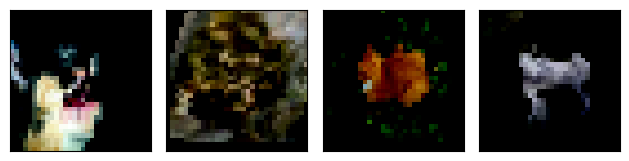

In [3]:
# Check the results of transformations
import matplotlib.pyplot as plt
images, _ = next(iter(train_data_loader))

fig, axs = plt.subplots(nrows=1, ncols=4)

for i in range(4):
    ax = axs[i]
    ax.imshow(images[i].numpy().transpose(1,2,0))
    ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
    
plt.tight_layout()
plt.show()

# 2) Build a model with dropout and batch normalization

Here we're going to build about the same model as we used before, but with two new layers: batch normalization and dropout.

**Question: what's the purpose of these operations? What's the proposed order of their disposition relative to other layers?**

**Task 2. Declare 4 blocks (nn.Sequential) of Custom model with the default parameters (unless otherwise stated):**

**1st block, convolutional)**

    - Convolution layer with 16 filters, kernel size equal to 3x3 and stride 1x1. Use ReLU as activation;
    - Max pool layer with kernel size 2;
    - Batch norm layer.
    
**2nd block, convolutional)**

    - Convolution layer with 32 filters, kernel size equal to 3x3 and stride 1x1. Use ReLU as activation;
    - Batch norm layer;
    - Dropout layer with probability of unit drop equal to 0.25.
    
**3rd block, convolutional)**

    - Convolution layer with 64 filters, kernel size equal to 3x3 and stride 1x1. Use ReLU as activation;
    - Batch norm layer;

**4th block, linear)**

    - Linear layer. If you stated the previous parameters properly, in_features should be 64*11*11. Set out_features as 256 and ReLU as activation;
    - Dropout layer with probability of unit drop equal to 0.1;
    - Final linear layer with size of output equals 10

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CustomModel(nn.Module):
    def __init__(self):
        super(CustomModel, self).__init__()
        # Build your model
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1), nn.ReLU(), nn.MaxPool2d(kernel_size=2, stride=2), nn.BatchNorm2d(16))
        self.conv2 = nn.Sequential(nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1), nn.ReLU(), nn.BatchNorm2d(32), nn.Dropout(p=0.25))
        self.conv3 = nn.Sequential(nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1), nn.ReLU(), nn.BatchNorm2d(64))
        self.linear1 = nn.Sequential(nn.Linear(64*11*11, 256), nn.ReLU(), nn.Dropout(p=0.1), nn.Linear(256, 10 ))
        

    def forward(self, x):
        # Propagate x through the network
        # Do not forget to flatten after the 3rd block
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = torch.flatten(x, 1)
        x = self.linear1(x)
        return F.log_softmax(x, dim=1)
    
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = CustomModel().to(device)

print(f'Device: {device}')

print(model)

Device: cpu
CustomModel(
  (conv1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.25, inplace=False)
  )
  (conv3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (linear1): Sequential(
    (0): Linear(in_features=7744, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=256, out_features=10, bias=True)
  )
)


# 3) Training pipeline upgrades: early stopping and LR scheduler

Early Stopping is a form of regularization, used to stop training when a monitored metric has stopped improving.


**Question: what kind of metric can we monitor? What's the benefit of using early stopping?**

Vanila Pytorch doesn't contain early stopping (check [Pytorch Ignite](https://pytorch.org/ignite/generated/ignite.handlers.early_stopping.EarlyStopping.html) for 'official' solution), so we have to write it it from scratch. Although, sometimes it's useful to have such a custom tool which you can tune to your specific needs.

**Task 3. Implement EarlyStopping class**

In [6]:
# Fill this class to stop when a certain value stop improving 
import operator
import numpy as np
class EarlyStopping():
    def __init__(self, tolerance=5, min_delta=0, mode='min'):
        '''
        :param tolerance: number of epochs that the metric doesn't improve
        :param min_delta: minimum improvement
        :param mode: 'min' or 'max' to minimize or maximize the metric
        '''
        
        '''
        You should keep these parameters,
        define a counter of __call__ falses and the previous best value of metric
        '''
        self.early_stop = False
        self.tolerance = tolerance
        self.min_delta = min_delta
        self.mode = mode
        self.counter = 0
        self.best_metric = np.inf if mode == 'min' else -np.inf
        self.operation = operator.gt if mode == 'min' else operator.lt
        pass
    
    def __call__(self, metric)->bool:
        ''' This function should return True if `metric` is not improving for
            'tolerance' calls
        '''
        delta = (metric - self.best_metric)

        if self.operation(self.min_delta, delta):
            self.best_metric = metric
            self.counter = 0
        else:
            self.counter += 1

        if self.counter >= self.tolerance:
            self.early_stop = True
        return self.early_stop


### Let's look how different LR-schedulers work

c:\Users\User\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


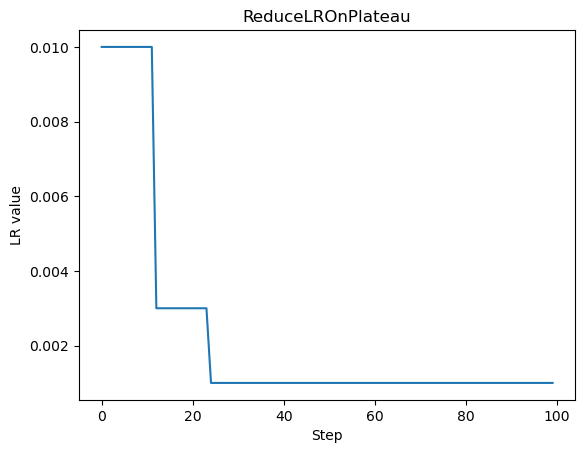

c:\Users\User\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:227: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


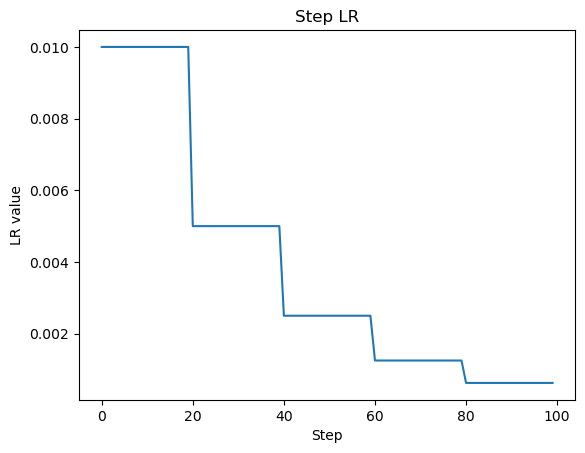

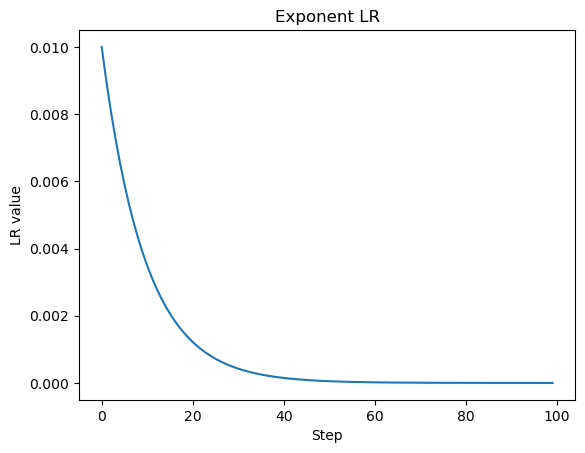

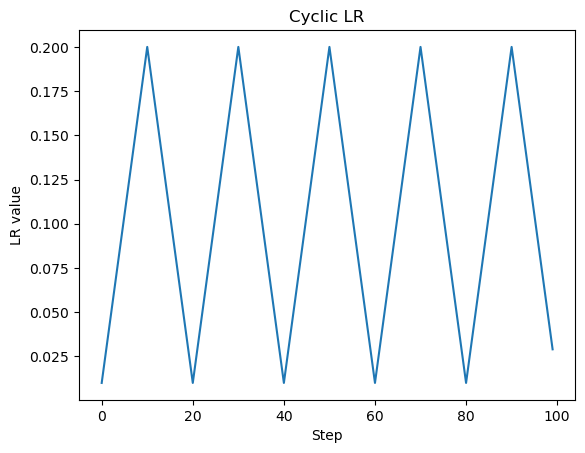

In [7]:
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt

# Just a toy model 
class NullModule(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(1,1)
    

toy_model = NullModule()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

def plot_lr(scheduler, name):
    # Re-init for each scheduler
    optimizer.param_groups[0]['lr'] = 0.01
    optimizer.zero_grad()
    toy_model.zero_grad()
    lrs = []
    step = 100
    
    fig, ax = plt.subplots()
    ax.set(xlabel='Step', ylabel='LR value', title=name)

    for i in range(step):
        lr = optimizer.param_groups[0]['lr']
        if name == "ReduceLROnPlateau":
            scheduler.step(lr) 
        else:
            scheduler.step()
        lrs.append(lr)

    ax.plot(lrs)
    plt.show()
    
    
# You can check https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
LRs = {"ReduceLROnPlateau": lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.3, 
                                                           patience=10, verbose=True,min_lr=0.001),
       "Step LR": lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5),
       "Exponent LR": lr_scheduler.ExponentialLR(optimizer, gamma=0.9),
       "Cyclic LR":lr_scheduler.CyclicLR(optimizer, base_lr=0.01, max_lr=0.2, 
                                         cycle_momentum=False, step_size_up=10)}

for name, lr in LRs.items():
    plot_lr(lr, name)


# 4) Gather all together in training loops

In [8]:
from time import time 
from tqdm import tqdm


def train(model, device, train_loader, criterion, optimizer, epoch):
    model.train()
    epoch_loss = 0
    start_time = time()
    correct = 0
    iteration = 0
    
    bar = tqdm(train_loader)
    for data, target in bar:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        
        output = model(data)
        # Get the index of the max log-probability
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()

        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        iteration += 1
        bar.set_postfix({"Loss": format(epoch_loss/iteration, '.6f')})

    acc = 100. * correct / len(train_loader.dataset)
    print(f'\rTrain Epoch: {epoch}, elapsed time:{time()-start_time:.2f}s')
    return epoch_loss, acc


def test(model, device, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
    
    acc = 100. * correct / len(test_loader.dataset)
    return test_loss, acc

In [11]:
from torch.optim import SGD
from copy import deepcopy

# Define hyperparams
epochs = 100


criterion = nn.CrossEntropyLoss()
optimizer = SGD(model.parameters(), lr=0.1, momentum=0.9)
# Choose the LR you like
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.3, 
                                                           patience=3, verbose=True, min_lr=0.001)
early_stopping = EarlyStopping(tolerance=7, mode='min')

best_model_wts = deepcopy(model.state_dict())
best_acc = 0.0

c:\Users\User\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


# 5) Use TensorBoard to check the progress of learning

In [ ]:
%load_ext tensorboard
%tensorboard --logdir runs

In [ ]:
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import copy



def training(writing=False):
    if writing:
        writer = SummaryWriter(log_dir='runs/model')

    best_acc = 0.0
    best_model_wts = copy.deepcopy(model.state_dict()) # Initialize best_model_wts here too, if it might not be assigned later.

    for epoch in range(1, epochs + 1):
        train_loss, train_acc = train(model, device, train_data_loader, criterion, optimizer, epoch)
        # Update learning rate if needed
        scheduler.step(train_loss)

        test_loss, test_acc = test(model, device, test_data_loader, criterion)
        # Terminate training if loss stopped to decrease
        if early_stopping(test_loss):
            print('\nEarly stopping\n')
            break
        # Deep copy the weight of model if its accuracy is the best for now
        if test_acc > best_acc:
            best_acc = test_acc
            best_model_wts = copy.deepcopy(model.state_dict())
        if writing:
            writer.add_scalars('Loss',
                            {
                                'train': train_loss,
                                'test': test_loss
                            },
                            epoch)

            writer.add_scalars('Accuracy',
                            {
                                'train': train_acc,
                                'test': test_acc
                            },
                            epoch)
        else:
            print(f"Training accuracy {train_acc}, test accuracy {test_acc}")
            print(f"Training loss {train_loss}, test loss {test_loss}")
        
    torch.save(model.state_dict(), "model.pt")
    model.load_state_dict(best_model_wts)
    torch.save(model.state_dict(), "best_model.pt")
    if writing:
        writer.close()
        
training()


100%|██████████| 391/391 [01:15<00:00,  5.17it/s, Loss=1.499870]


Train Epoch: 1, elapsed time:75.60s
Training accuracy 47.166, test accuracy 50.1
Training loss 586.4493561983109, test loss 107.98900353908539


100%|██████████| 391/391 [01:15<00:00,  5.15it/s, Loss=1.439260]


Train Epoch: 2, elapsed time:75.99s
Training accuracy 49.872, test accuracy 57.82
Training loss 562.7507308721542, test loss 100.26598107814789


100%|██████████| 391/391 [01:19<00:00,  4.89it/s, Loss=1.374276]


Train Epoch: 3, elapsed time:79.97s
Training accuracy 52.516, test accuracy 57.47
Training loss 537.3417376279831, test loss 101.3217705488205


100%|██████████| 391/391 [01:24<00:00,  4.64it/s, Loss=1.347782]


Train Epoch: 4, elapsed time:84.34s
Training accuracy 53.848, test accuracy 62.39
Training loss 526.9828045368195, test loss 91.29387992620468


100%|██████████| 391/391 [01:19<00:00,  4.92it/s, Loss=1.308169]


Train Epoch: 5, elapsed time:79.41s
Training accuracy 55.628, test accuracy 61.7
Training loss 511.49404060840607, test loss 95.50900679826736


100%|██████████| 391/391 [01:27<00:00,  4.48it/s, Loss=1.282347]


Train Epoch: 6, elapsed time:87.27s
Training accuracy 56.432, test accuracy 62.52
Training loss 501.3977379798889, test loss 90.41216570138931


100%|██████████| 391/391 [01:28<00:00,  4.42it/s, Loss=1.264669]


Train Epoch: 7, elapsed time:88.48s
Training accuracy 57.444, test accuracy 65.32
Training loss 494.48563301563263, test loss 82.99191391468048


100%|██████████| 391/391 [01:20<00:00,  4.83it/s, Loss=1.252338]


Train Epoch: 8, elapsed time:80.92s
Training accuracy 58.246, test accuracy 66.29
Training loss 489.6640341281891, test loss 80.65854477882385


100%|██████████| 391/391 [01:18<00:00,  4.97it/s, Loss=1.236539]


Train Epoch: 9, elapsed time:78.73s
Training accuracy 59.098, test accuracy 66.13
Training loss 483.48660373687744, test loss 84.600969851017


100%|██████████| 391/391 [01:18<00:00,  4.99it/s, Loss=1.196866]


Train Epoch: 10, elapsed time:78.35s
Training accuracy 60.006, test accuracy 66.73
Training loss 467.97454768419266, test loss 92.55594313144684


100%|██████████| 391/391 [01:19<00:00,  4.93it/s, Loss=1.227670]


Train Epoch: 11, elapsed time:79.36s
Training accuracy 59.458, test accuracy 65.84
Training loss 480.01886492967606, test loss 78.77530199289322


100%|██████████| 391/391 [01:30<00:00,  4.34it/s, Loss=1.207980]


Train Epoch: 12, elapsed time:90.10s
Training accuracy 60.278, test accuracy 68.5
Training loss 472.32034331560135, test loss 72.72912293672562


100%|██████████| 391/391 [01:22<00:00,  4.72it/s, Loss=1.199465]


Train Epoch: 13, elapsed time:82.91s
Training accuracy 60.826, test accuracy 69.67
Training loss 468.99094730615616, test loss 74.73655390739441


100%|██████████| 391/391 [01:23<00:00,  4.67it/s, Loss=1.191454]


Train Epoch: 14, elapsed time:83.77s
Training accuracy 61.144, test accuracy 70.21
Training loss 465.85868149995804, test loss 73.42503017187119


100%|██████████| 391/391 [01:29<00:00,  4.36it/s, Loss=1.144358]


Train Epoch: 15, elapsed time:89.71s
Training accuracy 62.382, test accuracy 66.51
Training loss 447.4441285729408, test loss 79.31921011209488


100%|██████████| 391/391 [01:15<00:00,  5.15it/s, Loss=1.183255]


Train Epoch: 16, elapsed time:75.95s
Training accuracy 61.334, test accuracy 68.78
Training loss 462.6525748372078, test loss 72.93105298280716


100%|██████████| 391/391 [01:19<00:00,  4.90it/s, Loss=1.156528]


Train Epoch: 17, elapsed time:79.83s
Training accuracy 62.516, test accuracy 70.4
Training loss 452.2025268673897, test loss 72.1178070306778


100%|██████████| 391/391 [01:30<00:00,  4.31it/s, Loss=1.133714]


Train Epoch: 18, elapsed time:90.82s
Training accuracy 63.11, test accuracy 67.51
Training loss 443.28235936164856, test loss 76.18584221601486


100%|██████████| 391/391 [01:16<00:00,  5.10it/s, Loss=1.158242]


Train Epoch: 19, elapsed time:76.68s
Training accuracy 62.272, test accuracy 70.73
Training loss 452.8727470636368, test loss 73.85982722043991


100%|██████████| 391/391 [01:14<00:00,  5.26it/s, Loss=1.163171]


Train Epoch: 20, elapsed time:74.33s
Training accuracy 62.67, test accuracy 67.06
Training loss 454.79997873306274, test loss 79.03641456365585


100%|██████████| 391/391 [01:14<00:00,  5.26it/s, Loss=1.131092]


Train Epoch: 21, elapsed time:74.39s
Training accuracy 63.656, test accuracy 68.61
Training loss 442.2570431828499, test loss 73.90260583162308


100%|██████████| 391/391 [01:19<00:00,  4.94it/s, Loss=1.160907]


Train Epoch: 22, elapsed time:79.08s
Training accuracy 62.712, test accuracy 72.0
Training loss 453.91454726457596, test loss 98.14503753185272


100%|██████████| 391/391 [01:14<00:00,  5.25it/s, Loss=1.135927]


Train Epoch: 23, elapsed time:74.41s
Training accuracy 63.74, test accuracy 72.65
Training loss 444.1473373770714, test loss 68.12744066119194


100%|██████████| 391/391 [01:14<00:00,  5.28it/s, Loss=1.123280]


Train Epoch: 24, elapsed time:74.11s
Training accuracy 63.776, test accuracy 71.16
Training loss 439.2025343775749, test loss 71.28872460126877


100%|██████████| 391/391 [01:14<00:00,  5.22it/s, Loss=1.112541]


Train Epoch: 25, elapsed time:74.87s
Training accuracy 64.352, test accuracy 72.35
Training loss 435.0034911632538, test loss 70.52187252044678


100%|██████████| 391/391 [01:14<00:00,  5.27it/s, Loss=1.119129]


Train Epoch: 26, elapsed time:74.25s
Training accuracy 64.152, test accuracy 67.28
Training loss 437.57941895723343, test loss 75.30047112703323


100%|██████████| 391/391 [01:13<00:00,  5.33it/s, Loss=1.144581]


Train Epoch: 27, elapsed time:73.41s
Training accuracy 63.688, test accuracy 71.0
Training loss 447.53131717443466, test loss 69.05713683366776


100%|██████████| 391/391 [01:14<00:00,  5.22it/s, Loss=1.115173]


Train Epoch: 28, elapsed time:74.89s
Training accuracy 64.536, test accuracy 72.7
Training loss 436.0324591398239, test loss 80.64443761110306


100%|██████████| 391/391 [01:14<00:00,  5.26it/s, Loss=1.137903]


Train Epoch: 29, elapsed time:74.28s
Training accuracy 63.856, test accuracy 72.27
Training loss 444.92014050483704, test loss 69.3725695014


100%|██████████| 391/391 [01:16<00:00,  5.10it/s, Loss=0.876675]


Train Epoch: 30, elapsed time:76.63s
Training accuracy 71.08, test accuracy 76.91
Training loss 342.7800031900406, test loss 58.18708297610283


100%|██████████| 391/391 [01:26<00:00,  4.50it/s, Loss=0.829687]


Train Epoch: 31, elapsed time:86.82s
Training accuracy 72.008, test accuracy 77.11
Training loss 324.4075919389725, test loss 55.28341422975063


100%|██████████| 391/391 [01:38<00:00,  3.99it/s, Loss=0.812407]


Train Epoch: 32, elapsed time:98.12s
Training accuracy 72.752, test accuracy 77.45
Training loss 317.6513212919235, test loss 53.15078064799309


100%|██████████| 391/391 [01:27<00:00,  4.47it/s, Loss=0.798040]


Train Epoch: 33, elapsed time:87.50s
Training accuracy 72.976, test accuracy 78.36
Training loss 312.03349870443344, test loss 56.31864860653877


100%|██████████| 391/391 [01:33<00:00,  4.19it/s, Loss=0.793269]


Train Epoch: 34, elapsed time:93.22s
Training accuracy 73.294, test accuracy 78.32
Training loss 310.1682457923889, test loss 51.13940557837486


100%|██████████| 391/391 [01:22<00:00,  4.76it/s, Loss=0.783547]


Train Epoch: 35, elapsed time:82.15s
Training accuracy 73.44, test accuracy 78.36
Training loss 306.36684435606, test loss 52.58744567632675


100%|██████████| 391/391 [01:21<00:00,  4.80it/s, Loss=0.774277]


Train Epoch: 36, elapsed time:81.46s
Training accuracy 73.608, test accuracy 78.25
Training loss 302.74243399500847, test loss 55.62765699625015


100%|██████████| 391/391 [01:17<00:00,  5.07it/s, Loss=0.760472]


Train Epoch: 37, elapsed time:77.05s
Training accuracy 74.256, test accuracy 77.92
Training loss 297.3447307050228, test loss 51.56851148605347


100%|██████████| 391/391 [01:16<00:00,  5.12it/s, Loss=0.756655]


Train Epoch: 38, elapsed time:76.33s
Training accuracy 74.116, test accuracy 78.77
Training loss 295.8519123196602, test loss 52.957045912742615


100%|██████████| 391/391 [01:15<00:00,  5.15it/s, Loss=0.756109]


Train Epoch: 39, elapsed time:75.95s
Training accuracy 74.178, test accuracy 78.79
Training loss 295.63873898983, test loss 52.9059593975544


100%|██████████| 391/391 [01:16<00:00,  5.09it/s, Loss=0.756316]


Train Epoch: 40, elapsed time:76.75s
Training accuracy 74.272, test accuracy 78.29
Training loss 295.7197196483612, test loss 50.676947355270386


100%|██████████| 391/391 [01:20<00:00,  4.88it/s, Loss=0.753082]


Train Epoch: 41, elapsed time:80.20s
Training accuracy 74.432, test accuracy 78.44
Training loss 294.45500123500824, test loss 54.38813355565071


100%|██████████| 391/391 [01:20<00:00,  4.86it/s, Loss=0.739984]


Train Epoch: 42, elapsed time:80.46s
Training accuracy 74.882, test accuracy 78.27
Training loss 289.33373671770096, test loss 50.79763004183769


100%|██████████| 391/391 [01:18<00:00,  4.97it/s, Loss=0.735483]


Train Epoch: 43, elapsed time:78.71s
Training accuracy 74.716, test accuracy 79.18
Training loss 287.57376232743263, test loss 49.58609926700592


100%|██████████| 391/391 [01:18<00:00,  5.00it/s, Loss=0.736146]


Train Epoch: 44, elapsed time:78.19s
Training accuracy 75.102, test accuracy 78.46
Training loss 287.83317029476166, test loss 51.18703380227089


100%|██████████| 391/391 [01:17<00:00,  5.06it/s, Loss=0.735075]


Train Epoch: 45, elapsed time:77.26s
Training accuracy 74.774, test accuracy 78.51
Training loss 287.41443356871605, test loss 51.34937450289726


100%|██████████| 391/391 [01:20<00:00,  4.88it/s, Loss=0.735220]


Train Epoch: 46, elapsed time:80.14s
Training accuracy 75.046, test accuracy 79.43
Training loss 287.47097036242485, test loss 50.40779474377632


100%|██████████| 391/391 [01:21<00:00,  4.80it/s, Loss=0.719447]


Train Epoch: 47, elapsed time:81.44s
Training accuracy 75.454, test accuracy 79.94
Training loss 281.30395805835724, test loss 49.383640825748444


100%|██████████| 391/391 [01:21<00:00,  4.78it/s, Loss=0.716353]


Train Epoch: 48, elapsed time:81.75s
Training accuracy 75.78, test accuracy 79.31
Training loss 280.0938458442688, test loss 49.61890405416489


100%|██████████| 391/391 [01:17<00:00,  5.07it/s, Loss=0.718599]


Train Epoch: 49, elapsed time:77.10s
Training accuracy 75.406, test accuracy 79.87
Training loss 280.9722600579262, test loss 49.80632624030113


100%|██████████| 391/391 [01:15<00:00,  5.17it/s, Loss=0.715011]


Train Epoch: 50, elapsed time:75.60s
Training accuracy 75.722, test accuracy 79.64
Training loss 279.5693591237068, test loss 51.14473882317543


100%|██████████| 391/391 [01:21<00:00,  4.82it/s, Loss=0.712834]


Train Epoch: 51, elapsed time:81.07s
Training accuracy 75.774, test accuracy 79.67
Training loss 278.718158274889, test loss 48.03703993558884


100%|██████████| 391/391 [01:22<00:00,  4.77it/s, Loss=0.708939]


Train Epoch: 52, elapsed time:82.04s
Training accuracy 75.852, test accuracy 79.2
Training loss 277.1953204870224, test loss 50.15314334630966


100%|██████████| 391/391 [01:22<00:00,  4.71it/s, Loss=0.706099]


Train Epoch: 53, elapsed time:82.94s
Training accuracy 75.814, test accuracy 79.64
Training loss 276.0848240554333, test loss 49.84401959180832


100%|██████████| 391/391 [01:16<00:00,  5.10it/s, Loss=0.694337]


Train Epoch: 54, elapsed time:76.62s
Training accuracy 76.364, test accuracy 79.41
Training loss 271.48579981923103, test loss 48.887508034706116


100%|██████████| 391/391 [01:14<00:00,  5.27it/s, Loss=0.692897]


Train Epoch: 55, elapsed time:74.27s
Training accuracy 76.36, test accuracy 80.01
Training loss 270.9226613342762, test loss 48.59631085395813


100%|██████████| 391/391 [01:19<00:00,  4.91it/s, Loss=0.696422]


Train Epoch: 56, elapsed time:79.70s
Training accuracy 76.098, test accuracy 79.77
Training loss 272.3010056912899, test loss 47.03697609901428


100%|██████████| 391/391 [01:20<00:00,  4.87it/s, Loss=0.694897]


Train Epoch: 57, elapsed time:80.28s
Training accuracy 76.094, test accuracy 80.35
Training loss 271.7048616707325, test loss 48.04043501615524


100%|██████████| 391/391 [01:26<00:00,  4.52it/s, Loss=0.686274]


Train Epoch: 58, elapsed time:86.48s
Training accuracy 76.6, test accuracy 79.72
Training loss 268.33296033740044, test loss 50.63161879777908


100%|██████████| 391/391 [01:16<00:00,  5.10it/s, Loss=0.699051]


Train Epoch: 59, elapsed time:76.60s
Training accuracy 76.094, test accuracy 79.45
Training loss 273.32886785268784, test loss 49.819593131542206


100%|██████████| 391/391 [01:17<00:00,  5.04it/s, Loss=0.691994]


Train Epoch: 60, elapsed time:77.64s
Training accuracy 76.232, test accuracy 80.12
Training loss 270.56957590579987, test loss 50.5320428609848


100%|██████████| 391/391 [01:17<00:00,  5.02it/s, Loss=0.685843]


Train Epoch: 61, elapsed time:77.89s
Training accuracy 76.434, test accuracy 80.81
Training loss 268.1644916534424, test loss 49.57219931483269


100%|██████████| 391/391 [01:17<00:00,  5.03it/s, Loss=0.684333]


Train Epoch: 62, elapsed time:77.71s
Training accuracy 76.626, test accuracy 79.66
Training loss 267.57422745227814, test loss 47.732742950320244


100%|██████████| 391/391 [01:19<00:00,  4.94it/s, Loss=0.676171]


Train Epoch: 63, elapsed time:79.09s
Training accuracy 76.862, test accuracy 80.75
Training loss 264.38283535838127, test loss 46.25021696090698


100%|██████████| 391/391 [01:20<00:00,  4.85it/s, Loss=0.674075]


Train Epoch: 64, elapsed time:80.66s
Training accuracy 76.81, test accuracy 81.07
Training loss 263.5633324980736, test loss 45.86906883120537


100%|██████████| 391/391 [01:13<00:00,  5.29it/s, Loss=0.674789]


Train Epoch: 65, elapsed time:73.93s
Training accuracy 76.97, test accuracy 79.92
Training loss 263.842306047678, test loss 49.00865691900253


100%|██████████| 391/391 [01:21<00:00,  4.77it/s, Loss=0.666925]


Train Epoch: 66, elapsed time:81.98s
Training accuracy 77.186, test accuracy 80.24
Training loss 260.7677429020405, test loss 48.05480366945267


100%|██████████| 391/391 [01:20<00:00,  4.87it/s, Loss=0.670581]


Train Epoch: 67, elapsed time:80.24s
Training accuracy 76.9, test accuracy 80.6
Training loss 262.1971383690834, test loss 49.729340344667435


100%|██████████| 391/391 [01:19<00:00,  4.91it/s, Loss=0.659815]


Train Epoch: 68, elapsed time:79.65s
Training accuracy 77.736, test accuracy 80.78
Training loss 257.98761346936226, test loss 47.967106848955154


100%|██████████| 391/391 [01:27<00:00,  4.46it/s, Loss=0.660746]


Train Epoch: 69, elapsed time:87.74s
Training accuracy 77.448, test accuracy 80.98
Training loss 258.3518449962139, test loss 48.55860456824303


100%|██████████| 391/391 [01:20<00:00,  4.86it/s, Loss=0.656837]


Train Epoch: 70, elapsed time:80.46s
Training accuracy 77.554, test accuracy 79.68
Training loss 256.82307639718056, test loss 54.50151541829109


100%|██████████| 391/391 [01:17<00:00,  5.04it/s, Loss=0.659353]


Train Epoch: 71, elapsed time:77.60s

Early stopping

